Import Necessary Libraries

In [1]:
from datetime import datetime
from pathlib import Path
from collections import Counter

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import seaborn as sns

from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.utils.data as data_utils
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F

Set up device to operate on

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

Mount Google Drive to configure dataset access

In [3]:
drive.mount('content/', force_remount = True)

Mounted at content/


In [ ]:
root_dir = 'content/My Drive/'
!ls "$root_dir/"

In [6]:
# pointing to the dataset directory on Google Drive
path = root_dir


!ls "{path}"

 Assignment_01_skeleton.ipynb  'Colab Notebooks'   sensor_readings_24.data


Load Dataset, Inspect, and Prepare

In [7]:
df = pd.read_csv(path+'sensor_readings_24.data', header = None, names=[f'feat{idx:02d}' for idx in range(1,25)]+['target'])
print("Shape:", df.shape)
df.head()

Shape: (5456, 25)


feat01  feat02  feat03  feat04  feat05  feat06  feat07  feat08  feat09  \
0   0.438   0.498   3.625   3.645     5.0   2.918     5.0   2.351   2.332   
1   0.438   0.498   3.625   3.648     5.0   2.918     5.0   2.637   2.332   
2   0.438   0.498   3.625   3.629     5.0   2.918     5.0   2.637   2.334   
3   0.437   0.501   3.625   3.626     5.0   2.918     5.0   2.353   2.334   
4   0.438   0.498   3.626   3.629     5.0   2.918     5.0   2.640   2.334   

   feat10  ...  feat16  feat17  feat18  feat19  feat20  feat21  feat22  \
0   2.643  ...   0.593   0.502   0.493   0.504   0.445   0.431   0.444   
1   2.649  ...   0.592   0.502   0.493   0.504   0.449   0.431   0.444   
2   2.643  ...   0.593   0.502   0.493   0.504   0.449   0.431   0.444   
3   2.642  ...   0.593   0.502   0.493   0.504   0.449   0.431   0.444   
4   2.639  ...   0.592   0.502   0.493   0.504   0.449   0.431   0.444   

   feat23  feat24             target  
0   0.440   0.429  Slight-Right-Turn  
1   0.443   0.429  Slight-Right-Turn  
2   0.446   0.429  Slight-Right-Turn  
3   0.444   0.429  Slight-Right-Turn  
4   0.441   0.429  Slight-Right-Turn  

[5 rows x 25 columns]

In [8]:
# Inspect the label distribution
Counter(df['target'])

Counter({'Slight-Right-Turn': 826,
         'Sharp-Right-Turn': 2097,
         'Move-Forward': 2205,
         'Slight-Left-Turn': 328})

In [9]:

classnames = list(df['target'].unique())

# to map text labels to numeric (integer encoding)
classname2label = {classname:classnames.index(classname) for classname in classnames}
classname2label

{'Slight-Right-Turn': 0,
 'Sharp-Right-Turn': 1,
 'Move-Forward': 2,
 'Slight-Left-Turn': 3}

In [10]:
# create and populate numeric label column
df['target_int'] = df['target'].map(classname2label)
df['target_int'].unique()

array([0, 1, 2, 3])

In [11]:
# verify the inclusion of the new column (numeric labels)
df.head()

feat01  feat02  feat03  feat04  feat05  feat06  feat07  feat08  feat09  \
0   0.438   0.498   3.625   3.645     5.0   2.918     5.0   2.351   2.332   
1   0.438   0.498   3.625   3.648     5.0   2.918     5.0   2.637   2.332   
2   0.438   0.498   3.625   3.629     5.0   2.918     5.0   2.637   2.334   
3   0.437   0.501   3.625   3.626     5.0   2.918     5.0   2.353   2.334   
4   0.438   0.498   3.626   3.629     5.0   2.918     5.0   2.640   2.334   

   feat10  ...  feat17  feat18  feat19  feat20  feat21  feat22  feat23  \
0   2.643  ...   0.502   0.493   0.504   0.445   0.431   0.444   0.440   
1   2.649  ...   0.502   0.493   0.504   0.449   0.431   0.444   0.443   
2   2.643  ...   0.502   0.493   0.504   0.449   0.431   0.444   0.446   
3   2.642  ...   0.502   0.493   0.504   0.449   0.431   0.444   0.444   
4   2.639  ...   0.502   0.493   0.504   0.449   0.431   0.444   0.441   

   feat24             target  target_int  
0   0.429  Slight-Right-Turn           0  
1   0.429  Slight-Right-Turn           0  
2   0.429  Slight-Right-Turn           0  
3   0.429  Slight-Right-Turn           0  
4   0.429  Slight-Right-Turn           0  

[5 rows x 26 columns]

In [12]:
# leave out the target columns from the input
dataX = df.drop(['target','target_int'], axis = 1)
print('dataset size:',len(dataX))
dataX.head()

dataset size: 5456


feat01  feat02  feat03  feat04  feat05  feat06  feat07  feat08  feat09  \
0   0.438   0.498   3.625   3.645     5.0   2.918     5.0   2.351   2.332   
1   0.438   0.498   3.625   3.648     5.0   2.918     5.0   2.637   2.332   
2   0.438   0.498   3.625   3.629     5.0   2.918     5.0   2.637   2.334   
3   0.437   0.501   3.625   3.626     5.0   2.918     5.0   2.353   2.334   
4   0.438   0.498   3.626   3.629     5.0   2.918     5.0   2.640   2.334   

   feat10  ...  feat15  feat16  feat17  feat18  feat19  feat20  feat21  \
0   2.643  ...   1.744   0.593   0.502   0.493   0.504   0.445   0.431   
1   2.649  ...   1.744   0.592   0.502   0.493   0.504   0.449   0.431   
2   2.643  ...   1.744   0.593   0.502   0.493   0.504   0.449   0.431   
3   2.642  ...   1.744   0.593   0.502   0.493   0.504   0.449   0.431   
4   2.639  ...   1.744   0.592   0.502   0.493   0.504   0.449   0.431   

   feat22  feat23  feat24  
0   0.444   0.440   0.429  
1   0.444   0.443   0.429  
2   0.444   0.446   0.429  
3   0.444   0.444   0.429  
4   0.444   0.441   0.429  

[5 rows x 24 columns]

In [13]:
# integer-coded data labels
Y = list(df['target_int'].copy())
np.unique(Y), len(Y)

(array([0, 1, 2, 3]), 5456)

In [14]:
# inspect the label distribution
labeldist = Counter(Y)
tmp = np.array(list(labeldist.values()))
print(tmp)
tmp/sum(tmp)*100

[ 826 2097 2205  328]


array([15.13929619, 38.43475073, 40.41422287,  6.01173021])

In [15]:
# convert pandas df to numpy ndarray
X = dataX.to_numpy()

# generate train-val and test splits
X_train_valid, X_test,Y_train_valid, Y_test = train_test_split(X, Y, test_size = 0.2, train_size = 0.8, random_state = 42, shuffle=True, stratify = Y )

# generate train and validation splits
X_train, X_valid,Y_train, Y_valid = train_test_split(X_train_valid, Y_train_valid, test_size = 0.25, train_size = 0.75, random_state = 42, shuffle=True, stratify = Y_train_valid )

scaler = MinMaxScaler()

X_train_normalized = scaler.fit_transform(X_train)

# Transform validation and test data using the scaler fitted on training data
X_valid_normalized = scaler.transform(X_valid)
X_test_normalized = scaler.transform(X_test)

# Check the shape of normalized data
print("Shape of X_train_normalized:", X_train_normalized.shape)
print("Shape of X_valid_normalized:", X_valid_normalized.shape)
print("Shape of X_test_normalized:", X_test_normalized.shape)

Shape of X_train_normalized: (3273, 24)
Shape of X_valid_normalized: (1091, 24)
Shape of X_test_normalized: (1092, 24)


In [16]:
# verify the ratio of the splits
len(Y_train), len(Y_valid), len(Y_test)

(3273, 1091, 1092)

Define the Neural Network

In [17]:
class RobotMoveModel(nn.Module):
    def __init__(self, n_feat, n_out):
        super().__init__()

        # normal (linear) layers
        self.lin1 = nn.Linear(n_feat, 10)
        self.lin2 = nn.Linear(10,10)
        self.lin3 = nn.Linear(10,10)
        self.lin4 = nn.Linear(10,10)
        self.lin5 = nn.Linear(10,10)
        self.lin6 = nn.Linear(10,10)
        self.lin7 = nn.Linear(10,5)
        self.lin8 = nn.Linear(5,n_out)


    # called during forward propagation
    def forward(self, x):

        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        x = F.relu(self.lin4(x))
        x = F.relu(self.lin5(x))
        x = F.relu(self.lin6(x))
        x = F.relu(self.lin7(x))
        x = self.lin8(x)

        # return the model output
        return x

Core functions

In [18]:
def get_optimizer(model, lr = 0.001, wd = 0.0):
    # the trainable model parameters
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    # create optimizer (Adam) with passed hyper-parameters
    optim = torch_optim.Adam(parameters, lr=lr, weight_decay=wd)

    return optim

In [19]:
def get_lr_scheduler(optim, max_lr, steps_per_epoch, epochs):
  # learning rate scheduler (OneCycle) to control the learning rate
  lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer = optim, max_lr = max_lr, steps_per_epoch = steps_per_epoch, epochs = epochs)

  return lr_scheduler

In [20]:
def train_model(model, optim, loss_fn, lr_scheduler, train_dl):
    # put the model in training mode
    model.train()

    # to keep track of loss
    total = 0
    sum_loss = 0

    # ground truth and predictions
    ys_true = []
    ys_pred = []

    for x, y in train_dl:  # one minibatch
        x, y, = x.to(device), y.to(device)  # move the data to the device being used (CPU/GPU)
        batch_sz = y.shape[0]   # minibatch size (since the last minibatch could be smaller than the others)
        out = model(x.float())  # compute the output of the network (forward propagation)
        loss = loss_fn(out.float(), y.long())   # compute the loss for the minibatch
        optim.zero_grad()   # reset the gradients of the optimizer so that it doesn't accumulate
        loss.backward()     # backpropagation (computes gradients of the loss w.r.t. to model parameters)
        optim.step()        # update the model parameters
        lr_scheduler.step() # update the learning rate according to the schedule
        total += batch_sz   # data points processed so far in the epoch
        sum_loss += batch_sz*(loss.item())  # aggregate loss
        preds = torch.argmax(out, dim = -1 )  # trainset predictions

        ys_pred.extend(preds.cpu()) # save the predictions
        ys_true.extend(y.cpu())     # save the ground truths

    return sum_loss/total, (ys_true, ys_pred)

In [21]:
def compute_val_loss(model, valid_dl,loss_fn):

    # put the model in evaluation mode
    model.eval()

    total = 0
    sum_loss = 0
    correct = 0

    ys_true = []
    ys_pred = []

    for x, y in valid_dl:
        x, y, = x.to(device), y.to(device)
        current_batch_size = y.shape[0]
        out = model(x.float())
        loss = loss_fn(out, y.long())
        sum_loss += current_batch_size*(loss.item())
        total += current_batch_size
        preds = torch.argmax(out, dim = -1 )
        correct += (preds == y).float().sum().item()

        ys_pred.extend(preds.cpu())
        ys_true.extend(y.cpu())

    return sum_loss/total, correct/total, (ys_true, ys_pred)

In [22]:
def train_loop(model, train_dl, valid_dl, epochs, lr=0.01, wd=0.0, class_weights = None):

    # get instances of the optimizer and the learning rate scheduler
    optim = get_optimizer(model, lr = lr/10, wd = wd)
    lr_scheduler = get_lr_scheduler(optim = optim, max_lr = lr, steps_per_epoch = len(train_dl), epochs = epochs )

    # initialize the loss function with the class weights if used
    if not class_weights is None:
      loss_fn = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights).float().to(device)) # weight=torch.from_numpy(class_weights,dtype=torch.float32)).to(device)
    else:
      loss_fn = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    for i in range(epochs): # one epoch
        train_loss, ys_true_pred_train = train_model(model, optim, loss_fn, lr_scheduler, train_dl) # train for one epoch
        val_loss, val_acc, ys_true_pred_val = compute_val_loss(model, valid_dl, loss_fn)            # validate

        # user feedback (progress and metrics)
        print(f'Epoch {i:02d}', end = " ")
        print(f"training loss: {train_loss:0.4f}", end = " ")
        print("valid loss %.3f and accuracy %.3f" % (val_loss, val_acc))

        # save the losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    # user feedback (train and validation loss curves)
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.ylim([0.0, max(train_losses+val_losses)+0.1])

    # user feedback (confusion matrix)
    cm = confusion_matrix(ys_true_pred_val[0], ys_true_pred_val[1], normalize='true')
    cm_df = pd.DataFrame(cm, index = classnames, columns = classnames)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix (Validation Dataset)')
    plt.ylabel('Actual (Ground Truth)')
    plt.xlabel('Predicted')
    plt.show()

Class weights

In [23]:
# one way: normalized reciprocal of relative frequencies
train_y_frequencies = Counter(Y_train)
class_weights = [None]*len(classnames)
for l, f in train_y_frequencies.items():
  class_weights[l] = len(Y_train)/f

class_weights = np.array(class_weights)/sum(class_weights)
class_weights

array([0.23256926, 0.09169662, 0.0871915 , 0.58854262])

In [24]:
# another way: using built-in functions

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(Y_train), y = Y_train)
class_weights

array([1.64969758, 0.6504372 , 0.61848073, 4.1747449 ])

Datasets and Dataloaders for the Pipeline

In [25]:
batch_size = 64

# create PyTorch datasets and dataloaders
train_dataset = data_utils.TensorDataset(torch.from_numpy(X_train_normalized), torch.Tensor(Y_train) )
train_dataloader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = data_utils.TensorDataset(torch.from_numpy(X_valid_normalized), torch.Tensor(Y_valid) )
valid_dataloader = data_utils.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

test_dataset = data_utils.TensorDataset(torch.from_numpy(X_test_normalized), torch.Tensor(Y_test) )
test_dataloader = data_utils.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Driver Cell

Epoch 00 training loss: 1.4219 valid loss 1.419 and accuracy 0.404
Epoch 01 training loss: 1.4156 valid loss 1.412 and accuracy 0.404
Epoch 02 training loss: 1.4097 valid loss 1.407 and accuracy 0.404
Epoch 03 training loss: 1.4039 valid loss 1.401 and accuracy 0.404
Epoch 04 training loss: 1.3984 valid loss 1.396 and accuracy 0.404
Epoch 05 training loss: 1.3930 valid loss 1.390 and accuracy 0.404
Epoch 06 training loss: 1.3877 valid loss 1.385 and accuracy 0.404
Epoch 07 training loss: 1.3828 valid loss 1.380 and accuracy 0.404
Epoch 08 training loss: 1.3780 valid loss 1.375 and accuracy 0.404
Epoch 09 training loss: 1.3731 valid loss 1.371 and accuracy 0.404
Epoch 10 training loss: 1.3683 valid loss 1.366 and accuracy 0.404
Epoch 11 training loss: 1.3641 valid loss 1.362 and accuracy 0.404
Epoch 12 training loss: 1.3606 valid loss 1.359 and accuracy 0.404
Epoch 13 training loss: 1.3578 valid loss 1.357 and accuracy 0.404
Epoch 14 training loss: 1.3553 valid loss 1.354 and accuracy 0

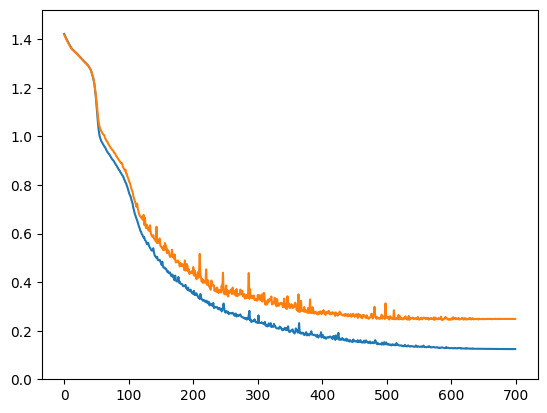

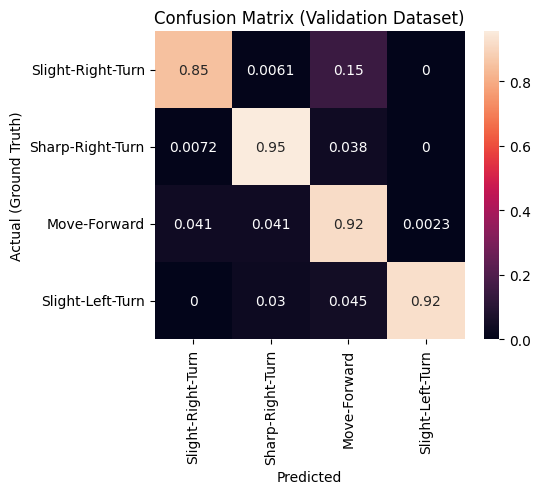

In [28]:

# instantiate the network
model = RobotMoveModel(n_feat = X.shape[-1], n_out = len(classnames))

# move the model to the appropriate device
model = model.to(device)

# start training and validation
train_loop(model, train_dataloader, valid_dataloader, epochs=700, lr=0.00117, wd=0.00001, class_weights = None)

Performance on the Test set (Use for reporting purposes only)

In [29]:
preds = []
total = 0
correct = 0

model.eval()

with torch.no_grad():
    for x ,y in test_dataloader:
        x, y = x.cuda(), y.cuda()
        current_batch_size = y.shape[0]
        total += current_batch_size
        out = model(x.float())
        pred = torch.argmax(out, axis = 1)
        correct += (pred == y).float().sum().item()

        prob = F.softmax(out, dim=1)
        preds.append(prob)

print(f'Test accuracy: {correct/total}')

Test accuracy: 0.9166666666666666
